In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.ion();

# Trabalho Final de Aprendizado de Máquina - Learning of Legends
---
_O quanto um modelo de aprendizado supervisionado é capaz de prever o time vencedor de uma partida profissional de League of Legends, baseando-se apenas em informações do começo do jogo? Isto é, uma vantagem criada no começo do jogo e composições de equipe são o suficiente para ditar o resultado de uma partida? Ainda, há ligas profissionais cujos resultados podemos prever mais facilmente? Modelos treinados com partidas de todas as ligas são geralmente bons ou é melhor treinar modelos específicos para cada liga?_

---

Como conjunto de dados, temos informações de partidas de ligas profissionais e campeonatos internacionais oficiais disputadas entre 2015 e 2017, totalizando 7620 observações. (Disponível em https://www.kaggle.com/chuckephron/leagueoflegends - Acesso em 25/06/2019) As informações incluem os campeões escolhidos por ambos os times, e valores como diferença de ouro e conquista de objetivos por minuto de jogo. 

Usando todos os atributos disponíveis sobre as partidas, a previsão do time vencedor torna-se trivial. O objetivo do trabalho é investigar a capacidade de solução desse problema a partir da abordagem de aprendizado supervisionado, fazendo uso de um conjunto limitado de informação.

---

## Tratamento dos Dados



In [145]:
lol = pd.read_csv("data/LeagueOfLegends.csv").drop("Unnamed: 0", axis=1)
lol.head()

,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,golddiff,...,redMiddleChamp,goldredMiddle,redADC,redADCChamp,goldredADC,redSupport,redSupportChamp,goldredSupport,redBans,Address
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...",...,Fizz,"[475, 475, 552, 842, 1178, 1378, 1635, 1949, 2...",Sneaky,Sivir,"[475, 475, 532, 762, 1097, 1469, 1726, 2112, 2...",LemonNation,Thresh,"[515, 515, 577, 722, 911, 1042, 1194, 1370, 14...","['Tristana', 'Leblanc', 'Nidalee']",http://matchhistory.na.leagueoflegends.com/en/...
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...",...,Azir,"[475, 475, 552, 786, 1097, 1389, 1660, 1955, 2...",CoreJJ,Corki,"[475, 475, 532, 868, 1220, 1445, 1732, 1979, 2...",KiWiKiD,Annie,"[515, 515, 583, 752, 900, 1066, 1236, 1417, 15...","['RekSai', 'Janna', 'Leblanc']",http://matchhistory.na.leagueoflegends.com/en/...
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...",...,Azir,"[475, 475, 533, 801, 1006, 1233, 1385, 1720, 1...",Cop,Corki,"[475, 475, 533, 781, 1085, 1398, 1782, 1957, 2...",BunnyFuFuu,Janna,"[515, 515, 584, 721, 858, 1002, 1168, 1303, 14...","['Leblanc', 'Zed', 'RekSai']",http://matchhistory.na.leagueoflegends.com/en/...
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...",...,Lulu,"[475, 475, 532, 771, 1046, 1288, 1534, 1776, 2...",KEITH,KogMaw,"[475, 475, 532, 766, 1161, 1438, 1776, 1936, 2...",Xpecial,Janna,"[515, 515, 583, 721, 870, 1059, 1205, 1342, 15...","['RekSai', 'Rumble', 'LeeSin']",http://matchhistory.na.leagueoflegends.com/en/...
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...",...,Lulu,"[475, 475, 532, 807, 1042, 1338, 1646, 1951, 2...",Maplestreet8,Corki,"[475, 475, 532, 792, 1187, 1488, 1832, 2136, 2...",Dodo8,Annie,"[475, 475, 538, 671, 817, 948, 1104, 1240, 136...","['Rumble', 'Sivir', 'Rengar']",http://matchhistory.na.leagueoflegends.com/en/...


Para não trabalhar com variáveis categóricas com muitos valores únicos, vamos reduzir a categoria das escolhas por posição do jogador de acordo com a função primária do personagem - `Mage`, `Fighter`, `Tank`, `Marksman`, `Assassin` ou `Support`.

In [144]:
import re

try:
    role = pd.read_csv("data/champion_role.csv")
    role.drop("Unnamed: 0", axis=1, inplace=True)
except FileNotFoundError:
    champions = pd.read_json("data/champion_info.json", orient="index").reset_index()
    role = pd.DataFrame({"name": champions.name.apply(lambda s: re.sub('[\'. ]', '', s).lower()),
                         "role": champions.tags.apply(lambda s: s[0])})
    role.to_csv("data/champion_role.csv")
role.head()

,name,role
0,aatrox,Fighter
1,ahri,Mage
2,akali,Assassin
3,alistar,Tank
4,amumu,Tank


In [4]:
# Diferença entre o número de possíveis valores para o personagem na posição Top, em comparação com o número de funções.
print(len(lol.blueTopChamp.unique()), len(role.role.unique()))

76 6


Vamos fazer algumas transformações para conseguir os atributos que queremos:
- Converter os objetivos absolutos em objetivos aos 15 minutos de jogo. 
    - Como queremos trabalhar com informações de começo do jogo, vamos criar outro dataset apenas com informações como a diferença de ouro (computada por `Ouro do Time Azul - Ouro do Time Vermelho`), as eliminações e abate de torres e objetivos apenas aos 15 minutos de jogo.
- Transformar os atributos categóricos para one-hot encoding.
    - Alguns métodos de aprendizado requerem esse formato de atributo.

In [125]:
try:
    lol_early = pd.read_csv("data/lol_early.csv")
    lol_early.drop("Unnamed: 0", axis=1, inplace=True)
    lol_early_ohe = pd.read_csv("data/lol_early_ohe.csv")
    lol_early_ohe.drop("Unnamed: 0", axis=1, inplace=True)
except FileNotFoundError:
    lol_early = pd.DataFrame()
    lol.replace("MonkeyKing", "Wukong", inplace=True)
    # Contexto da Partida
    lol_early["blueWins"] = lol.bResult
    lol_early["league"] = lol.League
    lol_early["season"] = lol.Year.apply(lambda y: str(y)) + " " + lol.Season
    lol_early["blueTop"] = lol.blueTopChamp.apply(lambda champ: role[role.name == re.sub('[\'. ]', '', champ).lower()].iloc[0].role)
    lol_early["redTop"] = lol.redTopChamp.apply(lambda champ: role[role.name == re.sub('[\'. ]', '', champ).lower()].iloc[0].role)
    lol_early["blueJungle"] = lol.blueJungleChamp.apply(lambda champ: role[role.name == re.sub('[\'. ]', '', champ).lower()].iloc[0].role)
    lol_early["redJungle"] = lol.redJungleChamp.apply(lambda champ: role[role.name == re.sub('[\'. ]', '', champ).lower()].iloc[0].role)
    lol_early["blueMiddle"] = lol.blueMiddleChamp.apply(lambda champ: role[role.name == re.sub('[\'. ]', '', champ).lower()].iloc[0].role)
    lol_early["redMiddle"] = lol.redMiddleChamp.apply(lambda champ: role[role.name == re.sub('[\'. ]', '', champ).lower()].iloc[0].role)
    lol_early["blueADC"] = lol.blueADCChamp.apply(lambda champ: role[role.name == re.sub('[\'. ]', '', champ).lower()].iloc[0].role)
    lol_early["redADC"] = lol.redADCChamp.apply(lambda champ: role[role.name == re.sub('[\'. ]', '', champ).lower()].iloc[0].role)
    lol_early["blueSupport"] = lol.blueSupportChamp.apply(lambda champ: role[role.name == re.sub('[\'. ]', '', champ).lower()].iloc[0].role)
    lol_early["redSupport"] = lol.redSupportChamp.apply(lambda champ: role[role.name == re.sub('[\'. ]', '', champ).lower()].iloc[0].role)
    
    # Extração da diferença de ouro/minuto em diferença de ouro aos 15 minutos, para cada posição
    lol_early["golddiffTeam15"] = lol.golddiff.apply(lambda s: int(s[1:-1].split(',')[14]))
    lol_early["golddiffTop15"] = lol.goldblueTop.apply(lambda s: int(s[1:-1].split(',')[14])) - lol.goldredTop.apply(lambda s: int(s[1:-1].split(',')[14]))
    lol_early["golddiffJungle15"] = lol.goldblueJungle.apply(lambda s: int(s[1:-1].split(',')[14])) - lol.goldredJungle.apply(lambda s: int(s[1:-1].split(',')[14]))
    lol_early["golddiffMiddle15"] = lol.goldblueMiddle.apply(lambda s: int(s[1:-1].split(',')[14])) - lol.goldredMiddle.apply(lambda s: int(s[1:-1].split(',')[14]))
    lol_early["golddiffADC15"] = lol.goldblueADC.apply(lambda s: int(s[1:-1].split(',')[14])) - lol.goldredADC.apply(lambda s: int(s[1:-1].split(',')[14]))
    lol_early["golddiffSupport15"] = lol.goldblueSupport.apply(lambda s: int(s[1:-1].split(',')[14])) - lol.goldredSupport.apply(lambda s: int(s[1:-1].split(',')[14]))
    
    # Extração de placar de eliminações aos 15 minutos
    lol_early["rKills15"] = lol.rKills.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for k in l if k[0] <= 15))
    lol_early["bKills15"] = lol.bKills.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for k in l if k[0] <= 15))
    
    # Extração do placar de Torres aos 15 minutos
    lol_early["rTowers15"] = lol.rTowers.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for t in l if t[0] <= 15))
    lol_early["bTowers15"] = lol.bTowers.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for t in l if t[0] <= 15))
    
    # Extração do placar de Inibidores aos 15 minutos
    lol_early["rInhibs15"] = lol.rInhibs.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for i in l if i[0] <= 15))
    lol_early["bInhibs15"] = lol.bInhibs.apply(lambda s: eval(s)).apply(lambda l: 0 if len(l)==0 else sum(1 for i in l if i[0] <= 15)) 
    
    lol_early.to_csv("data/lol_early.csv")
    
    #One-Hot Encoding
    lol_early_ohe = pd.get_dummies(lol_early)
    lol_early_ohe.to_csv("data/lol_early_ohe.csv")
    
    
lol_early.head()

,blueWins,league,season,blueTop,redTop,blueJungle,redJungle,blueMiddle,redMiddle,blueADC,...,golddiffJungle15,golddiffMiddle15,golddiffADC15,golddiffSupport15,rKills15,bKills15,rTowers15,bTowers15,rInhibs15,bInhibs15
0,1,NALCS,2015 Spring,Fighter,Fighter,Fighter,Mage,Mage,Assassin,Marksman,...,-467,565,-98,-43,0,1,0,0,0,0
1,0,NALCS,2015 Spring,Fighter,Fighter,Assassin,Tank,Mage,Mage,Marksman,...,514,131,-192,117,3,5,0,0,0,0
2,1,NALCS,2015 Spring,Fighter,Tank,Assassin,Fighter,Assassin,Mage,Marksman,...,55,1283,317,612,3,8,0,0,0,0
3,0,NALCS,2015 Spring,Fighter,Fighter,Tank,Support,Assassin,Support,Marksman,...,-1019,-42,312,-97,4,2,0,0,0,0
4,1,NALCS,2015 Spring,Fighter,Tank,Tank,Fighter,Mage,Support,Marksman,...,-657,-164,474,37,1,1,2,1,0,0


In [126]:
lol_early.columns

Index(['blueWins', 'league', 'season', 'blueTop', 'redTop', 'blueJungle',
       'redJungle', 'blueMiddle', 'redMiddle', 'blueADC', 'redADC',
       'blueSupport', 'redSupport', 'golddiffTeam15', 'golddiffTop15',
       'golddiffJungle15', 'golddiffMiddle15', 'golddiffADC15',
       'golddiffSupport15', 'rKills15', 'bKills15', 'rTowers15', 'bTowers15',
       'rInhibs15', 'bInhibs15'],
      dtype='object')

## Distribuições

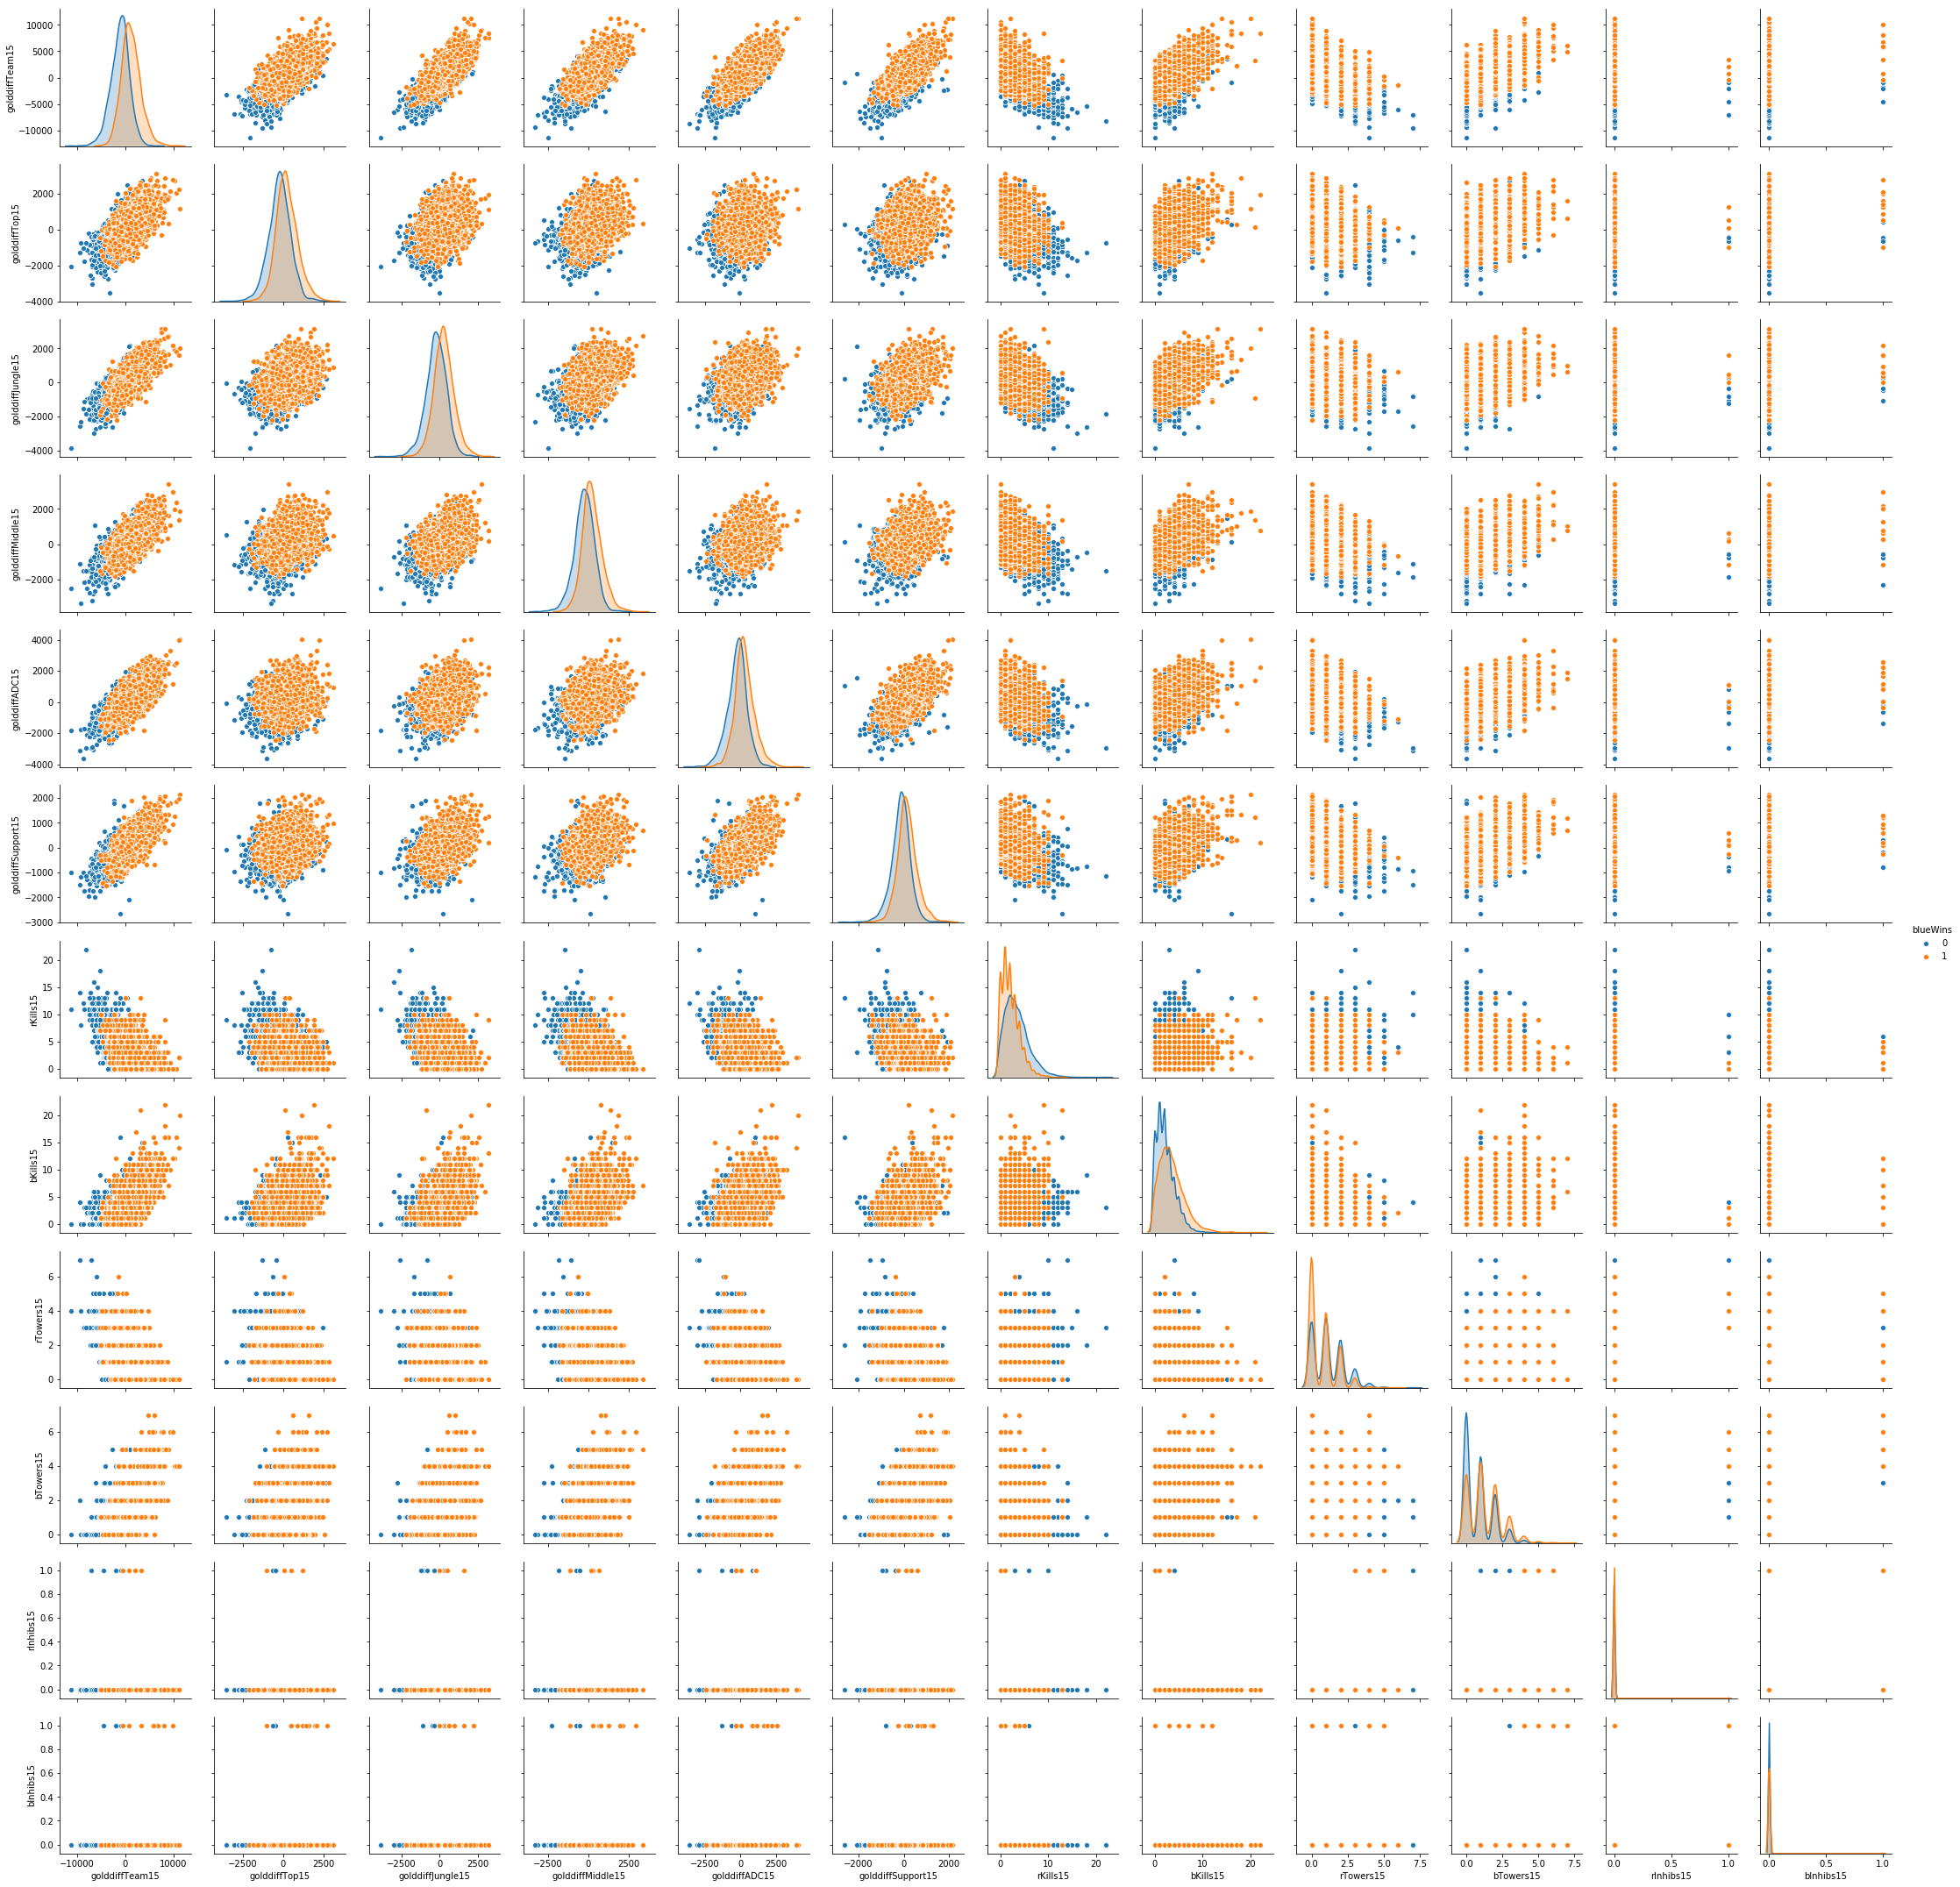

In [129]:
# Distribuições dos atributos numéricos
sns.pairplot(data=lol_early, x_vars=['golddiffTeam15', 'golddiffTop15',
       'golddiffJungle15', 'golddiffMiddle15', 'golddiffADC15',
       'golddiffSupport15', 'rKills15', 'bKills15', 'rTowers15', 'bTowers15',
       'rInhibs15', 'bInhibs15'], y_vars=['golddiffTeam15', 'golddiffTop15',
       'golddiffJungle15', 'golddiffMiddle15', 'golddiffADC15',
       'golddiffSupport15', 'rKills15', 'bKills15', 'rTowers15', 'bTowers15',
       'rInhibs15', 'bInhibs15'], hue="blueWins");

A partir da construção de árvores de decisão, é possível atribuir valores de importância para cada atributo na tarefa de classificação. Isto é, um atributo de maior importância explica melhor a divisão entre as classes de interesse.

Vamos analisar a importância de cada feature em Random Forests de árvores com divisões feitas a partir da métrica de Entropia.

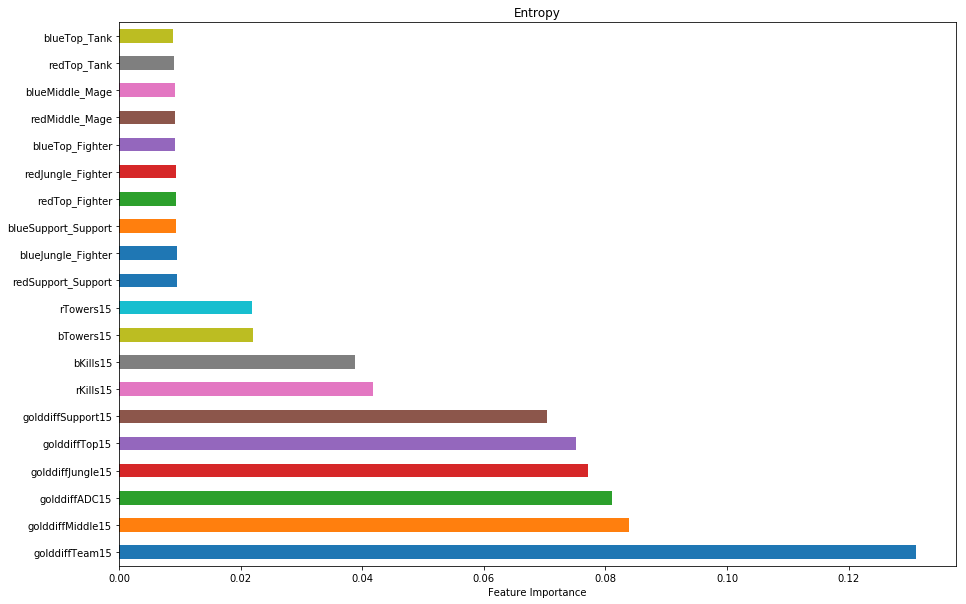

In [141]:
from sklearn.ensemble import RandomForestClassifier

X = lol_early_ohe.iloc[:,1:]
y = lol_early_ohe.iloc[:,0]

tree = RandomForestClassifier(n_estimators=500, criterion='entropy')
tree = tree.fit(X,y)
feat_importances = pd.Series(tree.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(20).plot(kind='barh', title="Entropy", figsize=(15,10))
ax.set_xlabel("Feature Importance");

Podemos ver que as diferenças em ouro são os atributos mais relevantes para as divisões, como esperado. Quanto maior uma vantagem criada no início do jogo, mais chance o time dominante tem de vencer.

É interessante notar que a diferença de ouro nas posições de Mid e ADC são as mais explicativas entre as diferenças em outras posições. Provavelmente porque têm maior impacto na conclusão de uma partida.